In [1]:
sys.path.append('../')
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
pd.set_option('max_columns', None)
import os

In [2]:
%%capture
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [4]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [5]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

In [6]:

litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.3, .7], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [7]:
print(train.shape, litho_data.shape)

(388971, 9) (1294715, 9)


In [8]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (248940, 7) (248940,)
### Validation Dataset: ###  (62236, 7) (62236,)
### Test Dataset: ###  (77795, 7) (77795,)


In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [11]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

In [12]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"gamma":0.5, "step_size":75},
                       lambda_sparse=0.1,
                       n_steps=8,
                       n_shared=2,
                       n_independent=5,
                       n_a=32,
                       momentum=0.1,
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                      )

Device used : cuda


In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)


In [14]:
max_epochs = 1000

clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs , patience=100,
    batch_size=1024,
    num_workers=0,
    weights=1,
    drop_last=False
)

| loss: 0.62113 | train_balanced_accuracy: 0.8188  | valid_balanced_accuracy: 0.73019 |  4:13:32s
epoch 209| loss: 0.62141 | train_balanced_accuracy: 0.82454 | valid_balanced_accuracy: 0.73874 |  4:14:44s
epoch 210| loss: 0.621   | train_balanced_accuracy: 0.82578 | valid_balanced_accuracy: 0.73602 |  4:15:55s
epoch 211| loss: 0.62237 | train_balanced_accuracy: 0.82317 | valid_balanced_accuracy: 0.7344  |  4:17:07s
epoch 212| loss: 0.61761 | train_balanced_accuracy: 0.82327 | valid_balanced_accuracy: 0.73821 |  4:18:19s
epoch 213| loss: 0.61797 | train_balanced_accuracy: 0.81645 | valid_balanced_accuracy: 0.73188 |  4:19:31s
epoch 214| loss: 0.6205  | train_balanced_accuracy: 0.82357 | valid_balanced_accuracy: 0.73491 |  4:20:46s
epoch 215| loss: 0.61881 | train_balanced_accuracy: 0.82365 | valid_balanced_accuracy: 0.7355  |  4:22:00s
epoch 216| loss: 0.61721 | train_balanced_accuracy: 0.82453 | valid_balanced_accuracy: 0.73673 |  4:23:15s
epoch 217| loss: 0.61972 | train_balanced_accu

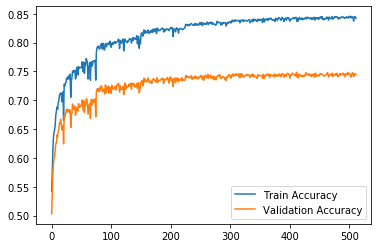

In [15]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

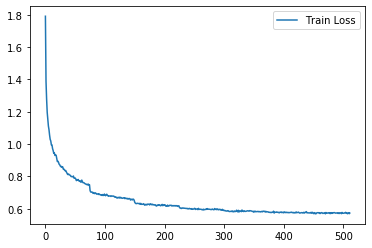

In [16]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()


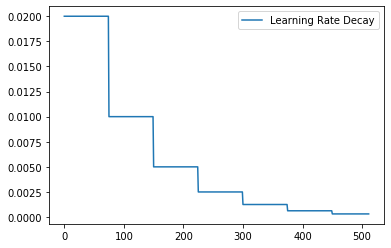

In [17]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()
